In [1]:
allure_etudier=1

In [2]:
import  sys

#LOCALISATION DES DONNEES
sys.path.insert(0, "C:/projets_python/diabolo")

import warnings
warnings.filterwarnings("ignore")




#LIBRAIRIES PERSO
import etude_variable.jouer as jj



# LIBRAIRIE PYHTON CLASSIQUES
import pandas as pd
import numpy as np
import matplotlib
import scipy
import platform

from collections import Counter

#ESTIMATEUR
import sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn import neighbors, datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer

from sklearn.ensemble import GradientBoostingClassifier



from scipy.stats import uniform
from scipy.stats import randint

#TRAINING
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
import dask_searchcv as dcv
from skopt.space import Real, Integer
from sklearn.model_selection import cross_validate

#Evaluateur
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectFromModel


from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.utils import class_weight

#outils
from dask.diagnostics import ProgressBar
import logging
from datetime import datetime
from sklearn.externals import joblib


#Metriques
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn import  metrics
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import  classification_report

#Outils

import time


#Graphique
from matplotlib import pyplot
from matplotlib import pyplot as plt
import seaborn as sns

print('Operating system version....', platform.platform())
print("Python version is........... %s.%s.%s" % sys.version_info[:3])
print('scikit-learn version is.....', sklearn.__version__)
print('pandas version is...........', pd.__version__)
print('numpy version is............', np.__version__)
print('matplotlib version is.......', matplotlib.__version__)
print('scipy version is.......', scipy.__version__)


Operating system version.... Windows-10-10.0.17134-SP0
Python version is........... 3.6.5
scikit-learn version is..... 0.19.1
pandas version is........... 0.22.0
numpy version is............ 1.14.2
matplotlib version is....... 2.2.0
scipy version is....... 1.0.0


Operating system version.... Windows-10-10.0.17134-SP0
Python version is........... 3.6.5
scikit-learn version is..... 0.19.1
pandas version is........... 0.22.0
numpy version is............ 1.14.2
matplotlib version is....... 2.2.0
scipy version is....... 1.0.0


In [3]:
def save_mymodel(clf, allure):
    print("Sauvegarde modele ...")
    joblib.dump(clf, 'diabolo' + str(allure) + '.pkl')
    
def load_mymodel(allure):
    print("Restauration modele ...")
    clf = joblib.load('diabolo' + str(allure) + '.pkl')
    return clf

    
    

In [4]:
model = load_mymodel(allure_etudier)
print(model)         

Restauration modele ...
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.3, learning_rate=0.07,
       max_delta_step=4, max_depth=10, max_features='sqrt',
       min_child_weight=13, missing=nan, n_estimators=1300, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=10,
       reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=400,
       silent=True, subsample=0.9)


In [5]:
xnames =jj.get_names()
xnames2 = jj.get_names2()

# xnames 2 = nouvelles colonnes du fichier transformé
# p2018 a été ajouté, SELECTION a été ajouté

df2=jj.restauration(allure_etudier=allure_etudier,xnames2=xnames2)
print(df2.info())


2018-07-14 16:02:23.992154



 Time taken: 0 hours 0 minutes and 2.49 seconds.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 238974 entries, 14 to 490294
Data columns (total 53 columns):
CO_PRIX                      238974 non-null int64
HIPPO                        238974 non-null int64
IDCOURSE                     238974 non-null int64
IDPARTCIPANT                 238974 non-null int64
PAR_AGE                      238974 non-null int64
PAR_CARRIERE                 238974 non-null float64
PAR_CARRIERE_Q               238974 non-null float64
PAR_CLASSE_AGE               238974 non-null float64
PAR_COTEDER                  238974 non-null int64
PAR_ENT_ECART_GAGNANT        238974 non-null int64
PAR_ENT_RAPPORT_GAGNANT_M    238974 non-null float64
PAR_ENT_REU_PLACE            238974 non-null float64
PAR_ENT_REUSSITE_GAGNE       238974 non-null float64
PAR_ENT_VICTOIRE             238974 non-null float64
PAR_GAIN                     238974 non-null float64
pAR_JOC_ECART_GAGNANT        238974 non-null int64
PAR_JOC_ECART_PLACE          238974 non-null int64
PAR_J

In [6]:


df2['SELECTION2']=df2['SELECTION2'].astype('float')
df2['SELECTION2']=df2['SELECTION2'].astype('int')
df2 = jj.suppression_colonne(df2=df2,allure=0)
df2 = jj.suppression_colonne(df2=df2,allure=allure_etudier)

# Creating bins for the win column
def assign_selection2(W):
    if W==1:
        return 1
    if W==0:
        return 0
    
    


Lib_features_df = df2.columns
xdata = df2.values

df_gagnant = pd.DataFrame(data=xdata, columns=Lib_features_df)
df_gagnant['SELECTION'] = df_gagnant['SELECTION2'].apply(assign_selection2)
df_gagnant.drop(["SELECTION2"], axis=1, inplace=True)

index_col = ['IDPARTCIPANT', 'IDCOURSE']
df_gagnant = df_gagnant.set_index(index_col)
df_gagnant_len = len(df_gagnant.columns) - 1
Lib_features = df_gagnant.columns[:df_gagnant_len]

feature_columns = Lib_features  ##<<<<<<<<<<<<<<<<
response_column = ['SELECTION']  ##<<<<<<<<<<<<<<<<

print("DEFINITION DE LA STRUCTURE ---------------------------------------------------------")
print("(1) Shape df_gagnant  ", df_gagnant.shape,"\n")
print("(2) FEATURES ",Lib_features)
print("(3) response column ",response_column)
# df_gagnant, feature_columns, response_column, ratio SONT DEFINI


Suppression colonnne  0


Suppression colonnne  1


DEFINITION DE LA STRUCTURE ---------------------------------------------------------
(1) Shape df_gagnant   (238974, 35) 

(2) FEATURES  Index(['PAR_AGE', 'PAR_CARRIERE', 'PAR_CARRIERE_Q', 'PAR_ENT_ECART_GAGNANT',
       'PAR_ENT_RAPPORT_GAGNANT_M', 'PAR_ENT_REU_PLACE',
       'PAR_ENT_REUSSITE_GAGNE', 'PAR_ENT_VICTOIRE', 'pAR_JOC_ECART_GAGNANT',
       'PAR_JOC_ECART_PLACE', 'PAR_JOC_NB_COURSE', 'PAR_JOC_PLACE_3P',
       'pAR_JOC_RAPPORT_GAGNANT_M', 'PAR_JOC_REU_PLACE',
       'pAR_JOC_REUSSITE_GAGNE', 'pAR_JOC_VICTOIRE', 'PAR_NUM', 'PAR_PLACE',
       'PAR_PLACE_Q', 'PAR_REUSSITE_3P', 'PAR_REUSSITE_GAGNE',
       'PAR_REUSSITE_QUINTE', 'PAR_RUESSITE_PLACE', 'Point', 'Nb_partant',
       'PAR_PROPRIO', 'NOM_JOC', 'NOM_ENTR', 'CHEVAL', 'PAR_ENT_ECART_PLACE',
       'PAR_VICTOIRE', 'PAR_VICTOIRE_Q', 'PAR_ENT_NB_COURSE', 'p2018'],
      dtype='object')
(3) response column  ['SELECTION']


Proportion: 12.45 : 1
Total number of records : 238974 
Nombre de participations avec SELECTION = 0 : 221202
Nombre de participations avec SELECTION = 1  : 17772
Pourcentage 0: 92.5632%,  pourcentage 1 : 7.4368%


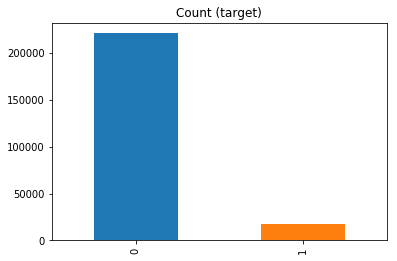

In [7]:

target_count = df_gagnant['SELECTION'].value_counts()

print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
target_count.plot(kind='bar', title='Count (target)')
normal_trans_perc = sum(df_gagnant['SELECTION'] == 0) / (sum(df_gagnant['SELECTION'] == 0) + sum(df_gagnant['SELECTION'] == 1))
fraud_trans_perc = 1 - normal_trans_perc
print('Total number of records : {} '.format(len(df_gagnant)))
print('Nombre de participations avec SELECTION = 0 : {}'.format(sum(df_gagnant['SELECTION'] == 0)))
print('Nombre de participations avec SELECTION = 1  : {}'.format(sum(df_gagnant['SELECTION'] == 1)))
print('Pourcentage 0: {:.4f}%,  pourcentage 1 : {:.4f}%'.format(normal_trans_perc * 100,fraud_trans_perc * 100))


In [8]:


#train_x, test_x, train_y, test_y = jj.split_data2(df_gagnant, feature_columns,response_column)
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df_gagnant[feature_columns],df_gagnant[response_column], test_size=0.30, random_state=42)

train_eval_X = df_gagnant[feature_columns]
train_eval_Y = df_gagnant[response_column]
print("SPLIT des données ....\n")

print("Train_x", train_x.shape)
print("Train y", train_y.shape)
print("")
print("Test x", test_x.shape)
print("Test y", test_y.shape)

#print("train_eval_X", train_eval_X.shape)
#print("train_eval_Y", train_eval_Y.shape)


#test_y = test_y['SELECTION'].ravel()
#train_y = train_y['SELECTION'].ravel()



train_x, train_y = jj.smot2(train_x=train_x, train_y=train_y, feature_columns=feature_columns)

print("apres SMOT2")
print("Train_x", train_x.shape)
print("Train y", train_y.shape)
#test_x, test_y = smot2(train_x=test_x, train_y=test_y, feature_columns=feature_columns)

SPLIT des données ....

Train_x (167281, 34)
Train y (167281, 1)

Test x (71693, 34)
Test y (71693, 1)
2018-07-14 16:02:31.894031


Fin SMOT

 Time taken: 0 hours 0 minutes and 1.48 seconds.
apres SMOT2
Train_x (309616, 34)
Train y (309616,)


In [9]:
def encodage(df_x):
    
    from sklearn import preprocessing
    #le = preprocessing.LabelEncoder()
    #df_gagnant[['HIPPO']] = le.fit_transform(df_gagnant[['HIPPO']])
    #df_gagnant[['PAR_PROPRIO']] = le.fit_transform(df_gagnant[['PAR_PROPRIO']])
    ##f_gagnant[['NOM_JOC']] = le.fit_transform(df_gagnant[['NOM_JOC']])
    #df_gagnant[['NOM_ENTR']] = le.fit_transform(df_gagnant[['NOM_ENTR']])
    #df_gagnant[['CHEVAL']] = le.fit_transform(df_gagnant[['CHEVAL']])
    #df_gagnant[['PAR_NUM']] = le.fit_transform(df_gagnant[['PAR_NUM']])
   # df_gagnant[['MUSIC_CHEVAL']] = le.fit_transform(df_gagnant[['MUSIC_CHEVAL']])

    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import quantile_transform

    #scaler = RobustScaler()
    scaler = RobustScaler( with_scaling=False, quantile_range=(25.0, 75.0), copy=False)
    critere_scale = ['CO_PRIX','PAR_CARRIERE',
                     'PAR_CLASSE_AGE',
                     'PAR_COTEDER','PAR_ENT_REU_PLACE',
                     'PAR_ENT_REUSSITE_GAGNE',
                     'PAR_ENT_VICTOIRE',
                     'PAR_GAIN',
                     'pAR_JOC_ECART_GAGNANT',
                     'PAR_JOC_ECART_PLACE',
                     'PAR_JOC_NB_COURSE',
                    'PAR_JOC_PLACE_3P',
                     'pAR_JOC_RAPPORT_GAGNANT_M',
                     'PAR_JOC_REU_PLACE',
                     'pAR_JOC_REUSSITE_GAGNE',
                     'pAR_JOC_VICTOIRE',
                    'PAR_PLACE_Q',
                     'PAR_REUSSITE_3P',
                     'PAR_REUSSITE_GAGNE', 
                     'PAR_REUSSITE_QUINTE',
                     'PAR_RUESSITE_PLACE',
                     'PAR_ENT_ECART_PLACE',
                     'PAR_VICTOIRE',
                     'Point',
                     
                     'PAR_VICTOIRE_Q',
                     'PAR_ENT_NB_COURSE',
                     'MY_REUSSITE_CHEVAL',
                     'POIDS',
                     'CO_PRIX',                     
                     'MY_REUSSITE_JOC',
                     'MY_REUSSITE_ENT',
                     'CLA_AGE_PRIX' ]
    
    


    #df_gagnant[critere_scale] = quantile_transform(df_gagnant[critere_scale], n_quantiles=4)

    #df_gagnant[critere_scale] = qt.fit_transform(df_gagnant[critere_scale])
    df_x[critere_scale] = quantile_transform(df_x[critere_scale], n_quantiles=100, random_state=0,subsample=300000)

    #df_x[critere_scale] = scaler.fit_transform(df_x[critere_scale])

    return df_x,critere_scale


In [10]:
def my_randomSearch(model, train_x,  train_y,  param_dist, n_iter_search):
    
  
    
    random_search =RandomizedSearchCV(            
            model,
            param_distributions=param_dist, 
        verbose=20,
           n_jobs=2,
        cv=10,
            refit=True,
          n_iter=n_iter_search,
            scoring='roc_auc'
        )
        
    model_search=random_search.fit(train_x, train_y)
    model_search= model_search.best_estimator_ 
    

    save_mymodel(model_search,allure_etudier)
    
    return model_search

In [11]:
def rechercheXGBClassifier(model, param_dist,train_x, train_y, test_x, test_y, feature_columns, iter_search):
    
    model = my_randomSearch(model, train_x,train_y , param_dist=param_dist,                                             
                                                                   n_iter_search=iter_search)   #   EVALUTION  **********************
    
    print("Meilleur model \n",model)

    y_pred = model.predict(test_x) 
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(test_y, predictions)
    print(">>>>  Accuracy: %.2f%%" % (accuracy * 100.0))

    print(classification_report(test_y, predictions))
    
    #jj.afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=1)
    
    
    print("-----------------------------------------------------------------------------------------------------------------------------------------------------")
    return model


In [12]:
model = load_mymodel(allure_etudier)
print(model)


Restauration modele ...
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.3, learning_rate=0.07,
       max_delta_step=4, max_depth=10, max_features='sqrt',
       min_child_weight=13, missing=nan, n_estimators=1300, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=10,
       reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=400,
       silent=True, subsample=0.9)


In [14]:

model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.3, learning_rate=0.07,
       max_delta_step=4, max_depth=10, max_features='sqrt',
       min_child_weight=13, n_estimators=1300, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=10,
       reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=400,
       silent=False, subsample=0.9)


In [ ]:
param_dist = {
                         "max_depth": range(6, 12,1),
                         "min_child_weight":range(11,14,1)                       
                        }    
    
model2=rechercheXGBClassifier(model, param_dist,train_x, train_y,  test_x, test_y,feature_columns=feature_columns,iter_search=5)


Sauvegarde modele ...


In [16]:
save_mymodel(clf=model2, allure=allure_etudier)



Sauvegarde modele ...


Restauration modele ...
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=1.0, gamma=1.0, learning_rate=0.012,
       max_delta_step=3, max_depth=14, max_features='sqrt',
       min_child_weight=6, missing=nan, n_estimators=2100, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=0.9)
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 16.5min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed: 16.5min
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed: 32.5min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 32.8min
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed: 48.6min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed: 48.9min
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed: 64.7min
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed: 65.1min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 80.8min
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed: 81.2min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed: 96.7min
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed: 97.0min
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed: 112.4min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 112.7min
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed: 128.0min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed: 128.1min
[Parallel(n_jobs=2)]

Sauvegarde modele ...
Meilleur model 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.012,
       max_delta_step=3, max_depth=14, max_features='sqrt',
       min_child_weight=6, missing=nan, n_estimators=2100, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=1)


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


>>>>  Accuracy: 79.63%
             precision    recall  f1-score   support

          0       0.82      0.94      0.88     46360
          1       0.60      0.29      0.39     13435

avg / total       0.77      0.80      0.77     59795


EVAL SET ....


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Evaluation TEST-----------------------------------------------------------------------
TEST roc_auc_score :  0.6174731145678567


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[137698   1577]
 [ 16440 122835]]


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[43684  2676]
 [ 9503  3932]]
Classification Correcte des données de test : 47616/59795    79.632%


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Score  TEST  :   79.632  ************************
-----------------------------------------------------------------------------------------------------------------------------------------------------


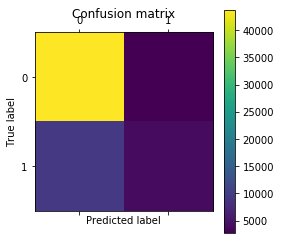

In [34]:
#save_mymodel(model,0)
model = load_mymodel(allure_etudier)
print(model)
            
param_dist = {                                         
                         'gamma':[i/10.0 for i in range(0,5)  ],      'subsample':[0.8,0.9,1],
                  'colsample_bytree':[0.5,0.6,0.7]
    
                        }    

    
model=rechercheXGBClassifier(model, param_dist,train_x, train_y,  test_x, test_y,feature_columns=feature_columns,iter_search=10)

Restauration modele ...
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.012,
       max_delta_step=3, max_depth=14, max_features='sqrt',
       min_child_weight=6, missing=nan, n_estimators=2100, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0.1, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=1)
Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 15.8min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed: 15.9min
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed: 31.2min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 31.7min
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed: 46.6min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed: 47.2min
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed: 61.9min
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed: 62.5min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 77.3min
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed: 77.9min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed: 90.5min
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed: 91.2min
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed: 103.9min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 104.4min
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed: 116.9min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed: 117.6min
[Parallel(n_jobs=2)]

Sauvegarde modele ...
Meilleur model 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.012,
       max_delta_step=3, max_depth=14, max_features='sqrt',
       min_child_weight=6, missing=nan, n_estimators=2100, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=1e-05, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=1)


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


>>>>  Accuracy: 79.69%
             precision    recall  f1-score   support

          0       0.82      0.94      0.88     46360
          1       0.60      0.29      0.39     13435

avg / total       0.77      0.80      0.77     59795


EVAL SET ....


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Evaluation TEST-----------------------------------------------------------------------
TEST roc_auc_score :  0.6174012670214464


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[137692   1583]
 [ 16355 122920]]


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[43736  2624]
 [ 9520  3915]]
Classification Correcte des données de test : 47651/59795    79.691%

Score  TEST  :   79.691  ************************
-----------------------------------------------------------------------------------------------------------------------------------------------------


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


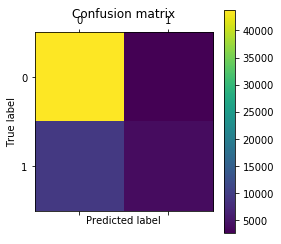

In [35]:
model = load_mymodel(allure_etudier)
print(model)            
param_dist = {
                         
                
     'reg_alpha':[0,1e-5, 1e-2, 0.1,0.2,0.3, 1, 100]
                       
                        }    
    
model=rechercheXGBClassifier(model, param_dist,train_x, train_y,  test_x, test_y,feature_columns=feature_columns,iter_search=7)

In [17]:
model = load_mymodel(allure_etudier)
print(model)            
param_dist = {                                         
           'n_estimators':range(1100, 2000, 100),
           'learning_rate':[i/100.0 for i in range(3,10)]                                 
                        }    
    
model=rechercheXGBClassifier(model, param_dist,train_x, train_y,  test_x, test_y,feature_columns=feature_columns,iter_search=5)

Restauration modele ...
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.3, learning_rate=0.07,
       max_delta_step=4, max_depth=11, max_features='sqrt',
       min_child_weight=12, missing=nan, n_estimators=1300, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=10,
       reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=400,
       silent=False, subsample=0.9)
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 22.0min


[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed: 28.0min


[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed: 49.6min


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 55.7min


[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed: 77.3min


[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed: 83.5min


[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed: 105.0min


[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed: 111.2min


[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 132.6min


[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed: 139.0min


[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed: 152.8min


[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed: 168.6min


[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed: 182.4min


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 198.2min


[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed: 211.9min


[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed: 227.6min


[Parallel(n_jobs=2)]: Done  17 tasks      | elapsed: 241.3min


[Parallel(n_jobs=2)]: Done  18 tasks      | elapsed: 257.1min


[Parallel(n_jobs=2)]: Done  19 tasks      | elapsed: 270.6min


[Parallel(n_jobs=2)]: Done  20 tasks      | elapsed: 286.6min


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 289.9min


[Parallel(n_jobs=2)]: Done  22 tasks      | elapsed: 316.0min


[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed: 319.3min


[Parallel(n_jobs=2)]: Done  24 tasks      | elapsed: 345.5min


[Parallel(n_jobs=2)]: Done  25 tasks      | elapsed: 348.8min


[Parallel(n_jobs=2)]: Done  26 tasks      | elapsed: 375.0min


[Parallel(n_jobs=2)]: Done  27 tasks      | elapsed: 378.2min


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 404.5min


[Parallel(n_jobs=2)]: Done  29 tasks      | elapsed: 407.6min


[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed: 419.6min


[Parallel(n_jobs=2)]: Done  31 tasks      | elapsed: 434.2min


[Parallel(n_jobs=2)]: Done  32 tasks      | elapsed: 437.7min


[Parallel(n_jobs=2)]: Done  33 tasks      | elapsed: 453.6min


[Parallel(n_jobs=2)]: Done  34 tasks      | elapsed: 457.4min


[Parallel(n_jobs=2)]: Done  35 tasks      | elapsed: 473.2min


[Parallel(n_jobs=2)]: Done  36 tasks      | elapsed: 477.0min


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 491.1min


[Parallel(n_jobs=2)]: Done  38 tasks      | elapsed: 494.7min


[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed: 508.9min


[Parallel(n_jobs=2)]: Done  40 tasks      | elapsed: 512.5min


[Parallel(n_jobs=2)]: Done  41 tasks      | elapsed: 529.4min


[Parallel(n_jobs=2)]: Done  42 tasks      | elapsed: 540.5min


[Parallel(n_jobs=2)]: Done  43 tasks      | elapsed: 557.6min


[Parallel(n_jobs=2)]: Done  44 tasks      | elapsed: 568.6min


[Parallel(n_jobs=2)]: Done  45 tasks      | elapsed: 585.6min


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 596.3min


[Parallel(n_jobs=2)]: Done  47 tasks      | elapsed: 613.5min


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed: 649.2min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed: 649.2min finished


Sauvegarde modele ...
Meilleur model 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.3, learning_rate=0.03,
       max_delta_step=4, max_depth=11, max_features='sqrt',
       min_child_weight=12, missing=nan, n_estimators=1700, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=10,
       reg_alpha=0.2, reg_lambda=1, scale_pos_weight=1, seed=400,
       silent=False, subsample=0.9)


>>>>  Accuracy: 92.47%
             precision    recall  f1-score   support

          0       0.93      0.99      0.96     66394
          1       0.45      0.09      0.15      5299

avg / total       0.90      0.92      0.90     71693

-----------------------------------------------------------------------------------------------------------------------------------------------------


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Restauration modele ...
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.04,
       max_delta_step=3, max_depth=14, max_features='sqrt',
       min_child_weight=6, missing=nan, n_estimators=1330, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=1e-05, reg_lambda=5.0, scale_pos_weight=1, seed=900,
       silent=False, subsample=1)
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  9.6min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  9.6min
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed: 18.8min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 19.2min
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed: 28.1min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed: 28.6min
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed: 37.5min
[Parallel(n_jobs=2)]: Done   8 out of  10 | elapsed: 37.9min remaining:  9.5min
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 47.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 47.1min finished


Sauvegarde modele ...
Meilleur model 
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.04,
       max_delta_step=3, max_depth=14, max_features='sqrt',
       min_child_weight=6, missing=nan, n_estimators=1330, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=1e-05, reg_lambda=5.0, scale_pos_weight=1, seed=100,
       silent=False, subsample=1)


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


>>>>  Accuracy: 79.27%
             precision    recall  f1-score   support

          0       0.82      0.94      0.88     46360
          1       0.58      0.29      0.39     13435

avg / total       0.77      0.79      0.77     59795


EVAL SET ....


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Evaluation TEST-----------------------------------------------------------------------
TEST roc_auc_score :  0.6153501078756791


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[138964    311]
 [  7651 131624]]


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[[43463  2897]
 [ 9496  3939]]
Classification Correcte des données de test : 47402/59795    79.274%

Score  TEST  :   79.274  ************************
-----------------------------------------------------------------------------------------------------------------------------------------------------


c:\python\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


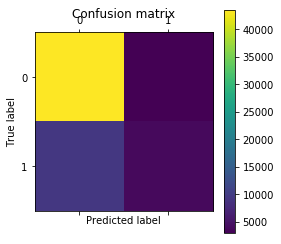

In [37]:
model = load_mymodel(allure_etudier)
print(model)            
param_dist = {                                         
           'seed':range(100, 1500, 90),
           'max_delta_step':range(1, 10, 1),                                 
                        }    
model=rechercheXGBClassifier(model, param_dist,train_x, train_y,  test_x, test_y,feature_columns=feature_columns,iter_search=1)

In [ ]:
model = load_mymodel(allure_etudier)
print(model)            
param_dist = {                                         
           'colsample_bylevel':[i/10.0 for i in range(1,9)],
           'reg_lambda':range(1, 10, 1),                     
    'scale_pos_weight':range(1, 10, 1),                                 
                        }    
model=rechercheXGBClassifier(model, param_dist,train_x, train_y,  test_x, test_y,feature_columns=feature_columns,iter_search=30)

Restauration modele ...
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=0.7, gamma=0.0, learning_rate=0.04,
       max_delta_step=3, max_depth=14, max_features='sqrt',
       min_child_weight=6, missing=nan, n_estimators=1330, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=1e-05, reg_lambda=5.0, scale_pos_weight=1, seed=100,
       silent=False, subsample=1)
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  9.7min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  9.7min
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed: 19.0min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 19.4min
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed: 28.4min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed: 28.9min
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed: 37.8min
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed: 38.3min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 47.2min
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed: 47.8min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed: 54.6min
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed: 55.3min
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed: 62.2min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 62.6min
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed: 69.6min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed: 70.0min
[Parallel(n_jobs=2)]: Do

[Parallel(n_jobs=2)]: Done 134 tasks      | elapsed: 465.3min
[Parallel(n_jobs=2)]: Done 135 tasks      | elapsed: 472.8min
[Parallel(n_jobs=2)]: Done 136 tasks      | elapsed: 472.8min
[Parallel(n_jobs=2)]: Done 137 tasks      | elapsed: 480.2min
[Parallel(n_jobs=2)]: Done 138 tasks      | elapsed: 480.2min
[Parallel(n_jobs=2)]: Done 139 tasks      | elapsed: 487.7min
[Parallel(n_jobs=2)]: Done 140 tasks      | elapsed: 487.7min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 495.3min
[Parallel(n_jobs=2)]: Done 142 tasks      | elapsed: 495.4min
[Parallel(n_jobs=2)]: Done 143 tasks      | elapsed: 502.8min
[Parallel(n_jobs=2)]: Done 144 tasks      | elapsed: 503.0min
[Parallel(n_jobs=2)]: Done 145 tasks      | elapsed: 510.2min
[Parallel(n_jobs=2)]: Done 146 tasks      | elapsed: 510.4min
[Parallel(n_jobs=2)]: Done 147 tasks      | elapsed: 517.6min
[Parallel(n_jobs=2)]: Done 148 tasks      | elapsed: 517.8min
[Parallel(n_jobs=2)]: Done 149 tasks      | elapsed: 525.1min
[Paralle

In [ ]:
model = load_mymodel(allure_etudier)
print("Modele final ...........")
print(model)            

In [ ]:
start_time=timer()
eval_set = [(train_x, train_y), (test_x, test_x)]
model.fit(train_x, train_y, eval_metric=["error", "auc"], eval_set=eval_set, verbose=False, early_stopping_rounds=300)

print("***********")
timer(start_time)          


In [ ]:
courbe_de_roc(estimator, test_x,test_y)

In [ ]:
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
PROBA = model.predict_proba(test_x)
 # evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print(">>>>>>>>>>  Accuracy: %.2f%%" % (accuracy * 100.0))
        

In [ ]:
    print(classification_report(test_y, predictions))

In [ ]:

        # retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

 # plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('auc')
pyplot.title('XGBoost auc')
pyplot.show()

        # plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

        #Plot_predictor_importance(best_model=model, feature_columns=featurecolums)

plot_importance(feature_columns=feature_columns,model=model)


In [ ]:
afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=1)
afficheEvalSet(model,train_x,train_y,test_x,test_y,type_eval=2)
y_pred = model.predict(test_x)
metrique_classe(y_pred=y_pred,y_true=test_y,xclass=0)
metrique_classe(y_pred=y_pred, y_true=test_y, xclass=1)
